<a href="https://colab.research.google.com/github/josh7197/DL_Finalproject_CS2470/blob/main/Model_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, Flatten, MaxPooling1D, GRU, Dropout,  Bidirectional, Attention, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing import sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.backend import flatten


import pandas as pd
import numpy as np
import re
import tensorflow as tf

!pip install keras-self-attention
!pip install keras-multi-head

from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHead

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CS2470/books_datasetv2.csv')
df.head()

,Unnamed: 0,ISBN,title,series,author,rating,genre,publish_company,format,number_of_pages,publish_month,publish_year,NYT_bestseller,top5,length_of_title,top_authors
0,0,9781419726552,"F*ck, That's Delicious: An Annotated Guide to ...",0,Action Bronson,4.17,food-and-drink,Harry N. Abrams,Hardcover,192,September,2017,1.0,0,57,0
1,1,9780982301821,10-Day Green Smoothie Cleanse: Lose Up to 15 P...,0,J.J. Smith,4.11,health,Adiva Publishing,Paperback,167,February,2014,1.0,0,63,0
2,2,9780316407076,15th Affair,1,James Patterson,4.09,mystery,Hachette,Hardcover,351,May,2016,1.0,1,11,1
3,3,9780718088804,42 Faith: The Rest of the Jackie Robinson Story,0,Ed Henry,4.16,biography,Harper Collins,Hardcover,368,April,2017,1.0,1,47,0
4,4,9780451495426,7 Lessons from Heaven: How Dying Taught Me to ...,0,Mary C. Neal,4.08,non-fiction,Convergent Books,Paperback,288,September,2017,1.0,0,68,0


In [ ]:
# select variables
X = df[['title', 'rating', 'number_of_pages', 'publish_year', 'top_authors']]
y = df['NYT_bestseller']

#Preprocessing
## y

In [ ]:
# Convert our labels into one-hot encoded vectors
label_encoder = preprocessing.LabelEncoder()


y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1001)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## X - text : title

In [ ]:

# dataTEXT - title

def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
    
X1_train = []
sentences = list(X_train["title"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))


X1_test = []
sentences = list(X_test["title"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))


# tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)



In [ ]:
# create word vectors
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/Shareddrives/CS2470/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## X - numeric : rating, number of pages, publish year

In [ ]:
X2_train = X_train[['rating', 'number_of_pages', 'publish_year']].values
X2_test = X_test[['rating', 'number_of_pages', 'publish_year']].values

X2_train = preprocessing.StandardScaler().fit_transform(X2_train)
X2_test = preprocessing.StandardScaler().fit_transform(X2_test)


 ## X - categorical : top_authors

In [ ]:
X3_train = preprocessing.OneHotEncoder().fit_transform(np.asarray(X_train['top_authors']).reshape(-1,1)).toarray()
X3_test = preprocessing.OneHotEncoder().fit_transform(np.asarray(X_test['top_authors']).reshape(-1,1)).toarray()


In [ ]:
X23_train = tf.concat([X2_train, X3_train], 1)
X23_test = tf.concat([X2_test, X3_test], 1)

# Create three input layers: X1 , X2, X3

In [ ]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(5,))

# single headed attention

In [ ]:
# input 1 - text
embedding_layer = Embedding(input_dim = 5000, mask_zero=True, output_dim = 128)(input_1)
x = Bidirectional(LSTM(units=20, return_sequences = True, dropout=0.5, recurrent_dropout=0.7))(embedding_layer)
x = SeqSelfAttention(attention_activation = 'sigmoid')(x)
x = GRU(128)(x)
x = Flatten()(x)
input_1_dense = Dense(32, activation='relu')(x)

# input 2 - numeric + binary
dense_layer_1 = Dense(256, activation='relu')(input_2)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
input_2_dense = Dense(32, activation='relu')(dense_layer_1)


# concat
concat_layer = Concatenate()([input_1_dense, input_2_dense])

dense_layer_3 = Dense(32, activation='relu')(concat_layer)
dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
output = Dense(2, activation='softmax')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 128)     640000      ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 200, 40)     23840       ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 seq_self_attention_1 (SeqSelfA  (None, 200, 40)     2625        ['bidirectional_2[0][0]']  

In [ ]:
train_fit = model.fit(x=[X1_train, X23_train], y = y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
9/9 [==============================] - 47s 4s/step - loss: 0.6453 - acc: 0.6987 - val_loss: 0.5940 - val_acc: 0.7311
Epoch 2/10
9/9 [==============================] - 29s 3s/step - loss: 0.5487 - acc: 0.7519 - val_loss: 0.4946 - val_acc: 0.7879
Epoch 3/10
9/9 [==============================] - 30s 3s/step - loss: 0.4529 - acc: 0.8089 - val_loss: 0.4129 - val_acc: 0.7917
Epoch 4/10
9/9 [==============================] - 30s 3s/step - loss: 0.3842 - acc: 0.8213 - val_loss: 0.3714 - val_acc: 0.8106
Epoch 5/10
9/9 [==============================] - 29s 3s/step - loss: 0.3587 - acc: 0.8308 - val_loss: 0.3473 - val_acc: 0.8144
Epoch 6/10
9/9 [==============================] - 29s 3s/step - loss: 0.3381 - acc: 0.8413 - val_loss: 0.3437 - val_acc: 0.8106
Epoch 7/10
9/9 [==============================] - 29s 3s/step - loss: 0.3427 - acc: 0.8260 - val_loss: 0.3427 - val_acc: 0.8144
Epoch 8/10
9/9 [==============================] - 28s 3s/step - loss: 0.3288 - acc: 0.8384 - val_loss: 0

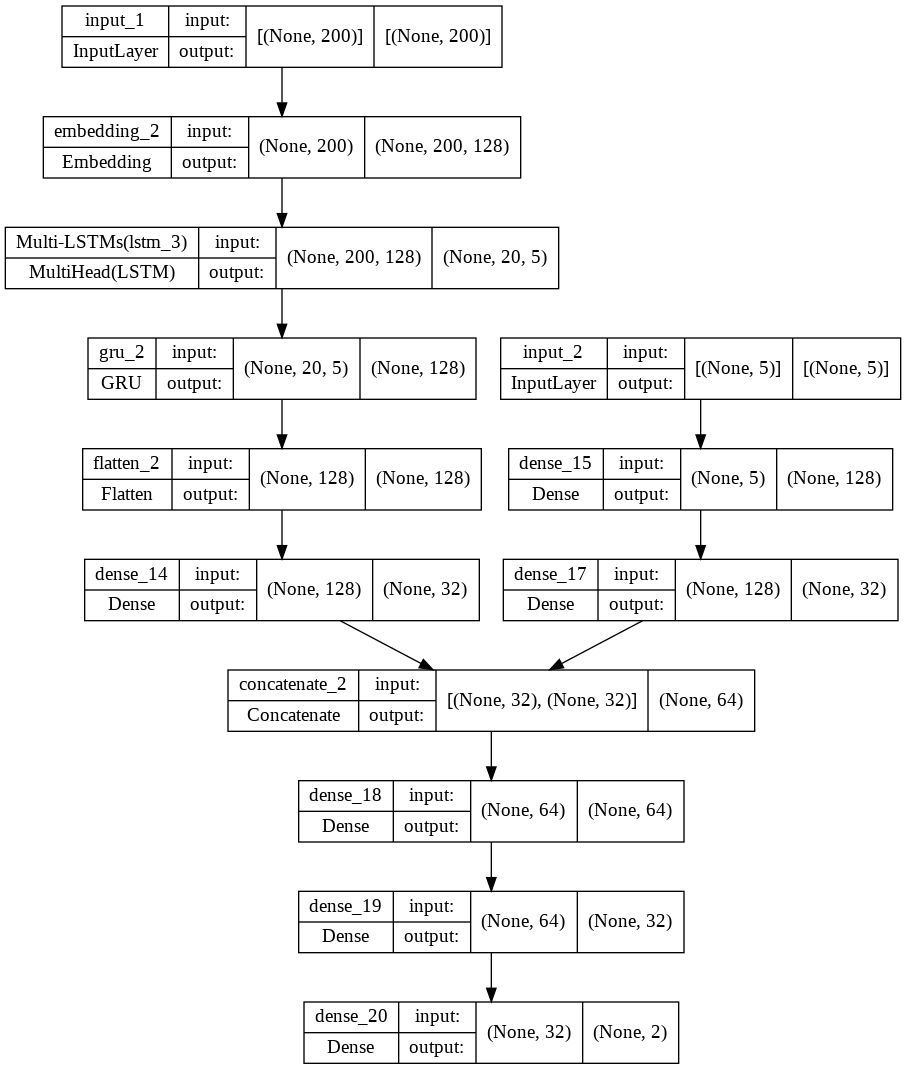

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
test_score = model.evaluate(x=[X1_test, X23_test], y=y_test, verbose=1)

print("Test Score:", test_score[0])
print("Test Accuracy:", test_score[1])

11/11 [==============================] - 3s 256ms/step - loss: 0.3585 - acc: 0.8303
Test Score: 0.3584737479686737
Test Accuracy: 0.8303030133247375


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_fit.history['acc'])
plt.plot(train_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(train_fit.history['loss'])
plt.plot(train_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Multi-headed-attention

In [ ]:
# input 1 - text
embedding_layer = Embedding(input_dim = 5000, mask_zero=True, output_dim = 128)(input_1)

x = MultiHead(LSTM(units=20), layer_num=5,name = 'Multi-LSTMs')(embedding_layer)
x = GRU(128)(x)
x = Flatten()(x)
input_1_dense = Dense(32, activation='relu')(x)

# input 2 - numeric + binary
dense_layer_1 = Dense(128, activation='relu', use_bias = True)(input_2)
dense_layer_2 = Dense(64, activation='relu', use_bias = True)(dense_layer_1)
input_2_dense = Dense(32, activation='relu')(dense_layer_1)


# concat
concat_layer = Concatenate()([input_1_dense, input_2_dense])

dense_layer_3 = Dense(64, activation='relu', use_bias = True)(concat_layer)
dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
output = Dense(2, activation='softmax')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 200, 128)     640000      ['input_3[0][0]']                
                                                                                                  
 Multi-LSTMs (MultiHead)        (None, 20, 5)        59600       ['embedding_4[0][0]']            
                                                                                                  
 gru_4 (GRU)                    (None, 128)          51840       ['Multi-LSTMs[0][0]']            
                                                                                            

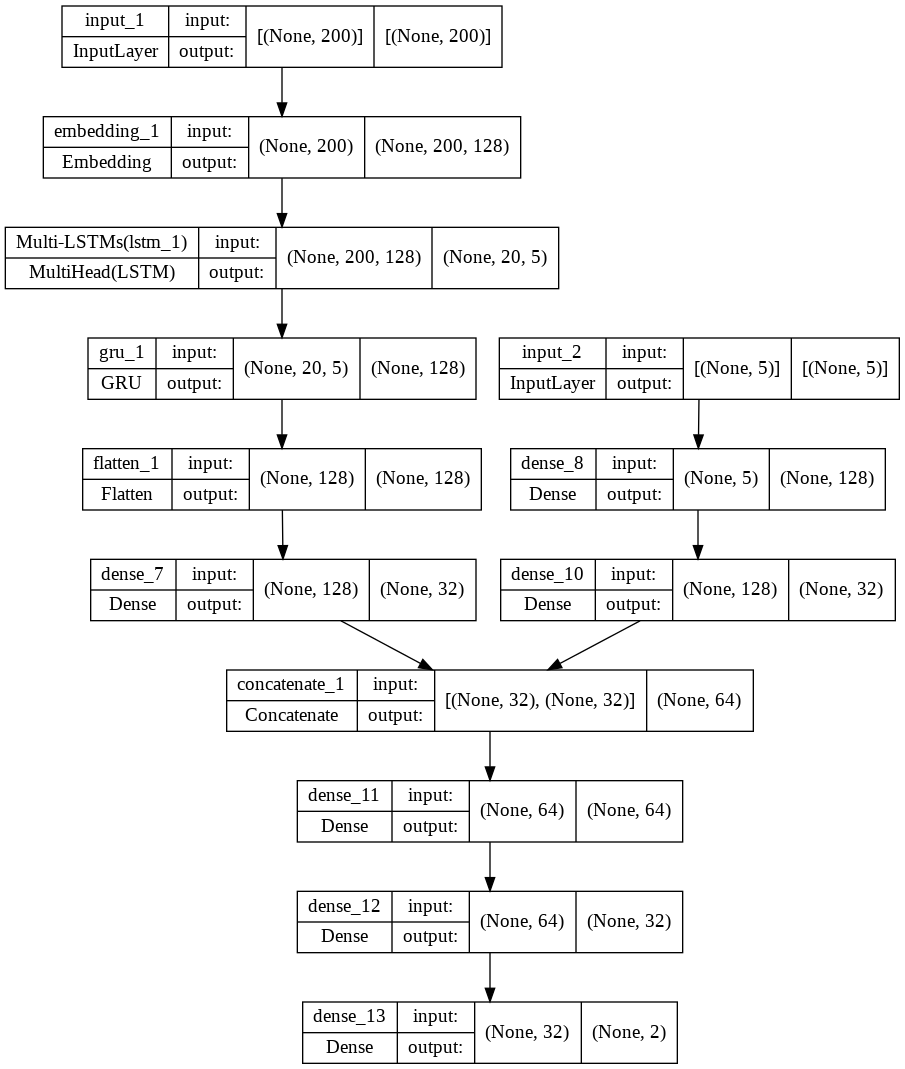

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_fit = model.fit(x=[X1_train, X23_train], y = y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
9/9 [==============================] - 41s 2s/step - loss: 0.6707 - acc: 0.6416 - val_loss: 0.6369 - val_acc: 0.6667
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 0.6152 - acc: 0.6797 - val_loss: 0.5794 - val_acc: 0.6780
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.5570 - acc: 0.7053 - val_loss: 0.5258 - val_acc: 0.7424
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.4929 - acc: 0.7861 - val_loss: 0.4628 - val_acc: 0.7841
Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.4266 - acc: 0.8108 - val_loss: 0.4115 - val_acc: 0.7917
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.3692 - acc: 0.8118 - val_loss: 0.3959 - val_acc: 0.7273
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.3207 - acc: 0.8403 - val_loss: 0.3726 - val_acc: 0.7576
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.2439 - acc: 0.9049 - val_loss: 0.3883 -

In [ ]:
test_score = model.evaluate(x=[X1_test, X23_test], y=y_test, verbose=1)

print("Test Score:", test_score[0])
print("Test Accuracy:", test_score[1])

11/11 [==============================] - 2s 190ms/step - loss: 0.6492 - acc: 0.7970
Test Score: 0.649228572845459
Test Accuracy: 0.7969697117805481


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_fit.history['acc'])
plt.plot(train_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(train_fit.history['loss'])
plt.plot(train_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()